## Crystal Growth

Here we demonstrate crystallisation on the surface of a liquid due to cooling from [@Guyer].

In [1]:
from __future__ import print_function
try:
    %matplotlib inline # can also use notebook or nbagg
except:
    pass

Before anything else let us set up the grid and the function space. We use the default DoF storage available in ```dune-fem``` - this can be changed for example to ```istl,eigen``` or ```petsc```.

In [2]:
import dune.fem as fem
from dune.grid import Marker, cartesianDomain
import dune.create as create
order = 1
dimDomain = 2     # we are solving this in 2d
dimRange = 2      # we have a system with two unknowns
domain = cartesianDomain([4, 4], [8, 8], [3, 3])
grid   = create.view("adaptive", grid="ALUConform",
                    constructor=domain, dimgrid=dimDomain)
space  = create.space("lagrange", grid, dimrange=dimRange, 
                order=order, storage="fem")

We want to solve the following system of equations of variables $\phi$ (phase field) and $T$ (temperature field)

\begin{gather}
\tau \frac{\partial \phi}{\partial t} = \nabla \cdot D \nabla \phi + \phi(1-\phi)m(\phi, T), \\
\frac{\partial T}{\partial t} = D_T \nabla^2 T + \frac{\partial \phi}{\partial t},
\end{gather}

where $D_T$ = 2.25, m is given by

\begin{equation}
m(\phi, T) = \phi - \frac{1}{2} - \frac{\kappa_1}{\pi} \arctan(\kappa_2 T),
\end{equation}

D is given by

\begin{equation}
D = \alpha^2(1+c\beta)\left(\begin{array}{cc}
1 + c\beta & -c \frac{\partial \beta}{\partial \psi} \\
c \frac{\partial \beta}{\partial \psi} & 1+c\beta
\end{array}\right),
\end{equation}

$\beta = \frac{1-\Phi^2}{1+\Phi^2}$, $\Phi = \tan \left( \frac{N}{2} \psi \right)$, $\psi = \theta + \arctan \left(\frac{\partial \phi/ \partial y}{\partial \phi / \partial x} \right)$ and $\theta$, $N$ are constants.

Let us first set up the parameters for the problem.

In [3]:
alpha        = 0.015
tau          = 3.e-4
kappa1       = 0.9
kappa2       = 20.
c            = 0.02
N            = 6.

We define the initial data and create a function from it. We use this value to set up our solution.

In [4]:
def initial(x):
    r  = (x - [6, 6]).two_norm
    return [ 0 if r > 0.3 else 1, -0.5 ]
initial_gf = create.function("global", grid, "initial", order+1, initial)
solution   = space.interpolate(initial_gf, name="solution")
solution_n = solution.copy()

As we will be discretising in time, we define the unknown data as $u = (\phi_1, \Delta T_1)$, while given data (from the previous time step) is $u_n = (\phi_0, \Delta T_0)$ and test function $v = (v_0, v_1)$.

In [5]:
from ufl import TestFunction, TrialFunction, Coefficient, Constant, triangle
u = TrialFunction(space)
v = TestFunction(space)
un = Coefficient(space)   # coefficient used in ufl for old solution
dt = Constant(triangle)      # set to time step size later on

For the numerical scheme, we discretise the time derivatives in the usual way, and we obtain the weak form by multiplying by a test function and integrating by parts. We also express the system using vectors.

This gets us the following equation.

\begin{equation}
\int \left( \alpha^2 \frac{dt}{\tau} (D_n\nabla \phi_1) \cdot \nabla v_0 + dt \ D_T \nabla T_1 \cdot \nabla v_1 + \textbf{u} \cdot \textbf{v} - \textbf{s} \cdot \textbf{v} \right) \ dx 
=
\int (\textbf{u}_n \cdot \textbf{v} - \phi_0 v_1) \ dx 
\end{equation}

where

\begin{equation}
\textbf{s} = \left( \frac{dt}{\tau}\phi_1(1-\phi_1)m(\phi_1, T_1), \phi_1 \right)^T
\end{equation}

and

$D_n$ is the anisotropic diffusion using the previous solution $\textbf{u}_n$ to compute the entries.

First we put in the right hand side which only contains explicit data.

In [6]:
from ufl import inner, dx
a_ex = (inner(un, v) - inner(un[0], v[1])) * dx

For the left hand side we have the spatial derivatives and the implicit parts.

In [7]:
from ufl import pi, atan, atan_2, tan, grad, as_vector, inner, dot
psi        = pi/8.0 + atan_2(grad(un[0])[1], (grad(un[0])[0]))
Phi        = tan(N / 2.0 * psi)
beta       = (1.0 - Phi*Phi) / (1.0 + Phi*Phi)
dbeta_dPhi = -2.0 * N * Phi / (1.0 + Phi*Phi)
fac        = 1.0 + c * beta
diag       = fac * fac
offdiag    = -fac * c * dbeta_dPhi
d0         = as_vector([diag, offdiag])
d1         = as_vector([-offdiag, diag])
m          = u[0] - 0.5 - kappa1 / pi*atan(kappa2*u[1])
s          = as_vector([dt / tau * u[0] * (1.0 - u[0]) * m, u[0]])
a_im = (alpha*alpha*dt / tau * (inner(dot(d0, grad(u[0])), grad(v[0])[0]) +
                                inner(dot(d1, grad(u[0])), grad(v[0])[1]))
       + 2.25 * dt * inner(grad(u[1]), grad(v[1])) 
       + inner(u,v) - inner(s,v)) * dx

equation = a_im == a_ex

We set up the model and the scheme with some parameters:

In [8]:
model  = create.model("elliptic", grid, equation, coefficients={un:solution_n} )
solverParameters = {
        "fem.solver.newton.tolerance": 1e-5,
        "fem.solver.newton.linabstol": 1e-8,
        "fem.solver.newton.linreduction": 1e-8,
        "fem.solver.newton.verbose": 0,
        "fem.solver.newton.linear.verbose": 0
    }
scheme = create.scheme("h1", space, model, solver="gmres",
        parameters=solverParameters)

We set up the adaptive method. We start with a marking strategy based on the value of the gradient of the phase field variable:

In [9]:
def mark(element):
    solutionLocal = solution.localFunction(element)
    grad = solutionLocal.jacobian(element.geometry.referenceElement.center)
    if grad[0].infinity_norm > 1.2:
        return Marker.refine if element.level < maxLevel else Marker.keep
    else:
        return Marker.coarsen

We do the initial refinement of the grid.

In [10]:
maxLevel = 11
hgrid    = grid.hierarchicalGrid
hgrid.globalRefine(6)
for i in range(0,maxLevel):
    hgrid.mark(mark)
    fem.adapt(hgrid,[solution])
    fem.loadBalance(hgrid,[solution])
    solution.interpolate(initial_gf)
    print(grid.size(0),end=" ")
print()

576 336 240 256 324 508 676 676 676 676 676 


Let us start by plotting the initial state of the material, which is just a small circle in the centre.

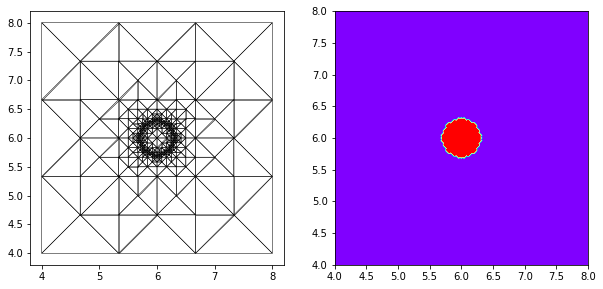

In [11]:
from dune.fem.plotting import plotComponents as plotComponents
import matplotlib.pyplot as pyplot
from dune.fem.function import levelFunction, partitionFunction
import matplotlib
vtk = grid.sequencedVTK("crystal", pointdata=[solution],
       celldata=[levelFunction(grid), partitionFunction(grid)])

matplotlib.rcParams.update({'font.size': 10})
matplotlib.rcParams['figure.figsize'] = [10, 5]
plotComponents(solution, cmap=pyplot.cm.rainbow, show=[0])

Some constants needed for the time loop:

In [12]:
timeStep     = 0.0005
model.setConstant(dt, timeStep)
t        = 0.0

Finally we set up the time loop and solve the problem - each time this cell is run the simulation will progress to the given ```endTime``` and then the result is shown. Just rerun it multiple times while increasing the ```endTime``` to progress the simulation further - this might take a bit...

In [13]:
endTime = 0.05
while t < endTime:
    solution_n.assign(solution)
    scheme.solve(target=solution)
    print(t,grid.size(0),end="\r")
    t += timeStep
    hgrid.mark(mark)
    fem.adapt(hgrid,[solution])
    fem.loadBalance(hgrid,[solution])
    # vtk()
print()

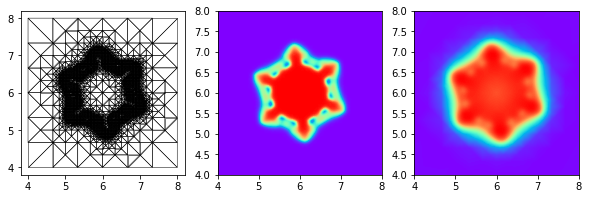

In [14]:
plotComponents(solution, cmap=pyplot.cm.rainbow)